In [64]:
import numpy as np
import scipy
import pickle
import time
import tqdm
import h5py

In [ ]:
"""
params
"""

def R(gstar,T):
    """
    (S46) in MeV. 
    """
    return 3.699*1e-10*(gstar**(-1/3))/T

def H(gstar,T):
    """
    (S44), and https://physics.nist.gov/cgi-bin/cuu/Value?plkmc2gev
    """
    return 1.660*(gstar**(1/2))*(T**2)/1.220890e22

def t(eta,t1):
    """
    (S6)
    """
    return (eta**2)*(t1)

def t_T(gstar,T):
    """
    (S45)
    """
    return 0.3012*(gstar**(-1/2))*1.220890e22/(T**2)

def T(gstar,t):
    """
    S(45)
    """
    return (0.3012*(gstar**(-1/2))*1.220890e22/t)**(1/2)

def init_PQ_params(fa,gstar):
    """
    these ARENT where you initialize, these are at eta = 1
    """
    T1 = (fa*1.220890e22/(1.660*(gstar**(1/2))))**(1/2)
    R1 = R(gstar,T1)
    t1 = t_T(gstar,T1)
    Tc = 1.68e-7*((400))
    return R1,T1,t1

def init_earlyQCD_params():
    #T1 = (fa*1.220890e22/(1.660*(gstar**(1/2))))**(1/2)

In [84]:
"""
evolve_utils
"""

def RK4(f,t,y,h):
    k1 = f(t,y)
    k2 = f(t+h/2,y+h*k1/2)
    k3 = f(t+h/2,y+h*k2/2)
    k4 = f(t+h,y+h*k3)
    return y + (1/6)*(k1+2*k2+2*k3+k4)*h

def grad(field,dir,order,N):
    """
    take derivative of a field, in a specific direction,
    with some number of points included (stencil number)
    This is a cheap-imitation of something that would use non-axis points 
    https://web.media.mit.edu/~crtaylor/calculator.html
    Probably thats what they meant by seven-point stencil though, the (2,3) scheme I wrote below

    Inputs:
        field: real numpy array
        dir: axis to compute
        order: order of derivative to compute
        N: number of points to include
    """
    
    if (order,N) == (2,3):
        return (np.roll(field,-1,axis=dir) + \
               -2*np.roll(field,-1,axis=dir) + \
               np.roll(field,1,axis=dir))
    if (order,N) == (2,7):
        return (2*np.roll(field,-3,axis=dir) + \
               -27*np.roll(field,-2,axis=dir) + \
               270*np.roll(field,-1,axis=dir) + \
               -490*field + \
               270*np.roll(field,1,axis=dir) + \
               -27*np.roll(field,2,axis=dir) + \
               2*np.roll(field,3,axis=dir))/180
    else:
        print(order,N)
        raise NotImplementedError

def rescaled_nabla(field,scale,N=3):
    """
    take rescaled nabla^2 of a field (defined under (S8))
    scale is "a"
    
    Inputs:
        field: 2 x N x N (x N)
    """
    n_space = len(field.shape) - 1
    to_return = np.zeros(field.shape)
    for i in range(1,n_space + 1):
        to_return = to_return + grad(field,i,2,N)
    return to_return*(scale**2)

def PQ_epoch_diff(eta,field,fieldp,R1,T1,t1,fa,gstar,scale,lamb=1,debug=False):
    """
    (S9) and (S10)
    y'' = f(t,y,y'), this is that function f. (in the PQ epoch)
    
    scale: how many lattice sites per a1H1. By the wording on page 2, it seems like
           the physical volume is held fixed. They have roughly 8 per. 
    
    """
    A = -(2/eta)*fieldp 
    B = rescaled_nabla(field,scale)#R(gstar,T(gstar,t(eta,t1)))/R1) 
    C = -lamb*field*((eta**2)*(np.repeat(np.expand_dims(np.sum(field**2,axis=0),0),2,0) - 1) + (T1**2)/(3*fa**2))
    #print("ABC",np.average(A),np.average(B),np.average(C))
    #print((T1**2)/(3*fa**2),(eta**2),R(gstar,T(gstar,t(eta,t1))),R1)
    return A + B + C

def earlyQCD_epoch_diff(eta,field,fieldp,scale,etac,lamb=5504,n=6.68,debug=False):
    A = -(2/eta)*fieldp 
    B = rescaled_nabla(field,scale)
    C = -lamb*field*(eta**2)*(np.repeat(np.expand_dims(np.sum(field**2,axis=0),0),2,0) - 1)
    D0 = (min(eta,etac)**n)*(eta**2)*(np.sum(field**2,axis=0)**(-3/2))
    D1 = -field[1]**2; D2 = field[0]*field[1]
    D = np.vstack((D1/D0,D2/D0))
    return A + B + C + D
    
def lateQCD_epoch_diff():
    pass

In [85]:
"""
evolve
"""

def evolve_PQ(shape,
              fa, 
              init_field, 
              init_fieldp, 
              etaini,
              deta, 
              Nstep,
              scale,
              stage,
              name=None,
              logdir=None,
              tolog=[],
              flush=100,
              debug=False):
    """
    Evolution in the PQ epoch

    Inputs
               shape : shape of spatial dims
                  fa : axion decay constant ~ 2.27e14 MeV
          init_field : fn that takes shape and spits out an initial config
          init_field : fn that takes shape and spits out an initial config'
              etaini : starting eta
                deta : d_eta
               Nstep : how many steps
                name : name of logfile
              logdir : where to save logfile
               tolog : list containing [("name",lambda f_fp: ..., how often to log this thing, shape of the thing, dtype),...]
               flush : how often to flush the logs
               debug : whether to print out semi-useless debug statements
    """
    
    if stage == 'PQ':
        R1,T1,t1 = init_PQ_params(fa,81)           #gstar fixed to 81 for now
    elif stage == 'earlyQCD':
        etac = init_earlyQCD_params()
    field    = init_field(shape)            #Init field
    fieldp   = init_fieldp(shape)           #and its derivative
    y_yp     = np.vstack((field,fieldp))    #Stackem
    eta      = etaini                       #initial eta
    
    for i in tqdm.tqdm(range(Nstep)):
        if debug:
            print("running",i,np.average(np.abs(y_yp)))
            time.sleep(1)

        if i%flush == 0:
            #print(f'{logdir}/{name}_{i//flush}.hdf5')
            logfile = h5py.File(f'{logdir}/{name}_{i//flush}.hdf5', 'w')
            datasets = []
            for x in tolog:
                datasets.append(logfile.create_dataset(x[0], (flush//x[2]+1,) + x[3], x[4]))

        for j,x in enumerate(tolog):
            if i%x[2] == 0:
                datasets[j][(i%flush)//x[2]] = x[1](y_yp)

        if i%flush == flush - 1:
            logfile.flush()
            logfile.close()
        
        if stage == 'PQ':
            y_yp = RK4(lambda eta,y_yp : \
                   np.vstack((y_yp[2:],PQ_epoch_diff(eta,y_yp[:2],y_yp[2:],R1,T1,t1,fa,81,scale,debug=debug))),
                   eta,y_yp,deta)
        elif stage == 'earlyQCD':
            
        eta += deta

    return 



In [86]:
"""
Thermal 
"""

def dummy_thermal(shape,eps=0.1):
    assert type(shape) is tuple
    return 2*eps*np.random.random((2,) + shape) - eps

In [123]:
evolve_PQ(shape=(1,),
          fa=2.27e14,
          init_field=lambda shape: np.random.random((2,1))-0.5,
          init_fieldp=lambda shape: np.random.random((2,1))-0.5,
          etaini=1000,
          deta=0.0004,
          Nstep=100,
          scale=8,
          name='test',
          logdir='/Users/joshlin/axion_cosmo/notebooks/misc',
          tolog=[("field",lambda f_fp:f_fp,1,(4,1),np.float64)],
         flush=100,)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3668.69it/s]


In [124]:
f = h5py.File('misc/test_0.hdf5','r')

(-1.0, 1.0)

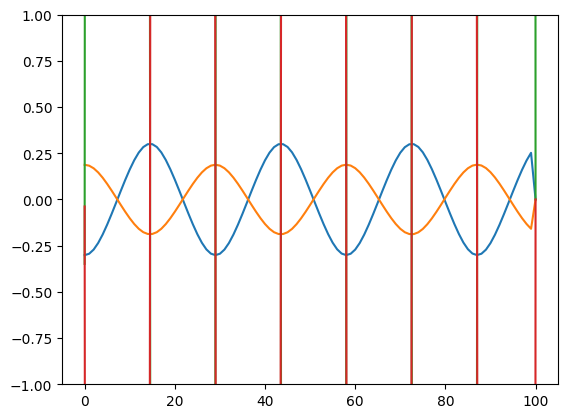

In [125]:
plt.plot(f['field'][:,0,0])
plt.plot(f['field'][:,1,0])
plt.plot(f['field'][:,2,0])
plt.plot(f['field'][:,3,0])
plt.ylim(-1,1)
#plt.xlim(0,1000)

In [122]:
f.close()

In [28]:
import logging
import h5py
import matplotlib.pyplot as plt

In [56]:
f = h5py.File('../tests/1_actualPQ/data/PQ_0.hdf5', 'r')

In [62]:
f.close()

In [57]:
f.keys()

<KeysViewHDF5 ['absav', 'av', 'field']>

In [58]:
f['field'].shape

(11, 4, 10, 10, 10)

In [61]:
f['field'][1,0,:,:,:]

array([[[0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.0006

In [37]:
f.keys()

<KeysViewHDF5 ['absav', 'av', 'field']>

In [30]:
f['absav'].shape

(100001, 4)

(-2.0, 2.0)

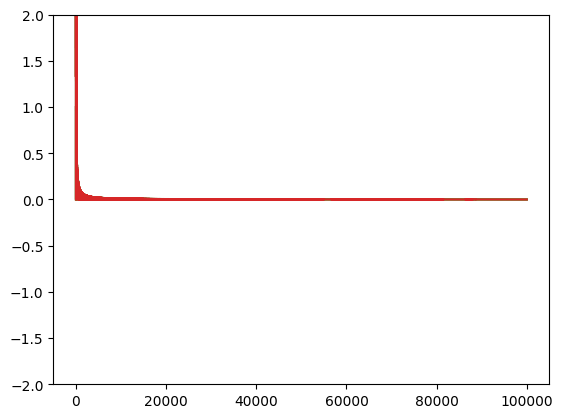

In [42]:
plt.plot(f['absav'][:,:])
plt.ylim(-2,2)

In [14]:
logging.basicConfig(filename='test')

In [ ]:
logging.

In [2]:
import pickle

In [3]:
x = pickle.load(open('../tests/1_actualPQ/data/point','rb'))

In [10]:
x['field'][-1]

(array([[[[-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          ...,
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167]],
 
         [[-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          ...,
          [-0